In [22]:
import os
import cv2
import random
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, random_split

In [23]:
if torch.cuda.is_available() == True:
       device = 'cuda:0'
       print('현재 가상환경 GPU 사용 가능 상태')
else:
       device = 'cpu'
       print('GPU 사용 불가능 상태')

GPU 사용 불가능 상태


In [24]:
def seed_everything(seed: int = 24):
       random.seed(seed)
       np.random.seed(seed)
       # torch.cuda.manual_seed(seed)
       # torch.backends.cudnn.deterministic = True
seed_everything()

In [25]:
tot_actions = 5
actions_name = 'backward', 'sit', 'slide', 'swing', 'walk'
min_data_len = 30

In [26]:
actions_csv_dir = '../csv_1214/'
dataset = []

label_mapping = {'backward': 0,
                 'sit': 1,
                 'slide': 2,
                 'swing': 3,
                 'walk' : 4
                 }

def map_action_to_label(csv_name):
       for action, label in label_mapping.items():
              if action in csv_name.split('_')[0]:
                     return label
       return -1

discard_csv = ['swing_10', 'swing_11', 'swing_12']

for action_csv in os.listdir(actions_csv_dir):
       action_df = pd.read_csv(os.path.join(actions_csv_dir, action_csv))
       
       label = map_action_to_label(action_csv)
       if label != -1:
              for idx in range(0, len(action_df), int(min_data_len / 2)):
                     seq_df = action_df[idx: idx + min_data_len] #길이만큼 데이터 자른 것(즉 length 만큼의 프레임)
                     if len(seq_df) == min_data_len: # 딱 length에 개수 맞춰서 끊어서 넣으려고
                            dataset.append({'key': label, 'value': seq_df}) # key에 slide, value에는 묶음 프레임 만큼이 담기겠네
       #최종적으로 dataset에는 행동별로 dictionary 가 만들어져 들어간다.

In [27]:
print(len(dataset[0]['value'].columns)) # z축 까지 99 (33 * 3)차원

75


In [28]:
class MyDataset(Dataset):
       def __init__(self, dataset): #모든 행동을 통합한 df가 들어가야함
              self.x = []
              self.y = []
              for dic in dataset:
                     self.y.append(dic['key']) #key 값에는 actions 들어감
                     self.x.append(dic['value']) #action마다의 data 들어감

       def __getitem__(self, index): #index는 행동의 index
              data = self.x[index] # x에는 꺼내 쓸 (행동마다 45개 묶음프레임)의 데이터
              label = self.y[index]
              return torch.Tensor(np.array(data)), torch.tensor(np.array(int(label)))

       def __len__(self):
              return len(self.x)


In [29]:
train_test_val_ratio = [0.8, 0.1, 0.1]
print(len(dataset))
train_len = int(len(dataset) * train_test_val_ratio[0])
val_len = int(len(dataset) * train_test_val_ratio[1])
test_len = len(dataset) - train_len - val_len
print('{}, {}, {}'.format(train_len, val_len, test_len))

1004
803, 100, 101


In [30]:
CFG = {'batch_size': 32,
       'learning_rate': 1e-3,
       'seed':24,
       'epochs': 100   
}

In [31]:
train_dataset = MyDataset(dataset)
train_data, valid_data, test_data = random_split(train_dataset, [train_len, val_len, test_len])

train_loader = DataLoader(train_data, batch_size=CFG['batch_size'])
val_loader = DataLoader(valid_data, batch_size=CFG['batch_size'])
test_loader = DataLoader(test_data, batch_size=CFG['batch_size'])

In [32]:
class Model1(nn.Module):
       def __init__(self):
              super(Model1, self).__init__()
              self.lstm1 = nn.LSTM(input_size=75, hidden_size=128, num_layers=1, batch_first=True) #input은  45 * 3(x, y z)
              self.lstm2 = nn.LSTM(input_size=128, hidden_size=256, num_layers=1, batch_first=True)
              self.lstm3 = nn.LSTM(input_size=256, hidden_size=512, num_layers=1, batch_first=True)
              self.dropout1 = nn.Dropout(0.1)
              self.lstm4 = nn.LSTM(input_size=512, hidden_size=256, num_layers=1, batch_first=True)
              self.lstm5 = nn.LSTM(input_size=256, hidden_size=128, num_layers=1, batch_first=True)
              self.lstm6 = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, batch_first=True)
              self.dropout2 = nn.Dropout(0.1)
              self.lstm7 = nn.LSTM(input_size=64, hidden_size=32, num_layers=1, batch_first=True)
              self.fc = nn.Linear(32, 5) #분류할 클래스 5가지

       def forward(self, x):
              x, _ = self.lstm1(x)
              x, _ = self.lstm2(x)
              x, _ = self.lstm3(x)
              x = self.dropout1(x)
              x, _ = self.lstm4(x)
              x, _ = self.lstm5(x)
              x, _ = self.lstm6(x)
              x = self.dropout2(x)
              x, _ = self.lstm7(x)
              x = self.fc(x[:, -1, :])
              return x

In [33]:
import torch.nn.functional as F
import torch.nn.init as init

class Model2(nn.Module):
       def __init__(self):
              super(Model2, self).__init__()
              self.recurrent_layer = nn.LSTM(hidden_size=100, input_size=75, bidirectional=False)
              self.nonLin = nn.BatchNorm1d(30)


              self.recurrent_layer2 = nn.LSTM(hidden_size=100, input_size=100, bidirectional=False) # biLSTM이라 input 2배로 늘림
              self.nonLin2 = nn.BatchNorm1d(30)

              self.conv = nn.Conv1d(30, 36, 7, 1)
              self.activation = nn.ReLU()  # or Leaky ReLU activation..?


              #self.dropout = nn.Dropout(0.5)
              self.classify_layer = nn.Linear(296, 5)

              # # Weight initialization
              # init.xavier_uniform_(self.conv.weight)
              # init.xavier_uniform_(self.classify_layer.weight)

       def forward(self, input, h_t_1=None, c_t_1=None):
              rnn_outputs, (hn, cn) = self.recurrent_layer(input)
              lin1 = self.nonLin(rnn_outputs)

              rnn_outputs2, (hn2, cn2) = self.recurrent_layer2(lin1)

              lin2 = self.nonLin2(rnn_outputs2)
              conv = self.conv(lin2)
              activation = self.activation(conv)
              
              activation = activation.view(activation.size(0), -1)

              logits = self.classify_layer(activation)
              return logits


In [34]:
import torch.nn.functional as F
import torch.nn.init as init

class Model3(nn.Module):
       def __init__(self):
              super(Model3, self).__init__()
              self.recurrent_layer = nn.LSTM(hidden_size=100, input_size=75, bidirectional=True)             
              self.nonLin = nn.BatchNorm1d(30)

              
              self.recurrent_layer2 = nn.LSTM(hidden_size=100, input_size=200, bidirectional=True) # biLSTM이라 input 2배로 늘림
              self.nonLin2 = nn.BatchNorm1d(30)
              
              self.conv = nn.Conv1d(30, 36, 7, 1)
              self.activation = nn.ReLU()  # or Leaky ReLU activation..?
              
              
              #self.dropout = nn.Dropout(0.5)
              self.classify_layer = nn.Linear(194, 5) # LSTM 출력 차원: 100, 두 번째 nn.BatchNorm1d 출력 차원: 35, nn.Conv1d 출력 차원: 36, : 100 + 35 + 36 = 171

              # # Weight initialization
              # init.xavier_uniform_(self.conv.weight)
              # init.xavier_uniform_(self.classify_layer.weight)

       def forward(self, input, h_t_1=None, c_t_1=None):
              rnn_outputs, (hn, cn) = self.recurrent_layer(input)
              lin1 = self.nonLin(rnn_outputs)

              rnn_outputs2, (hn2, cn2) = self.recurrent_layer2(lin1)

              lin2 = self.nonLin2(rnn_outputs2)
              conv = self.conv(lin2)
              activation = self.activation(conv)
              
              logits = self.classify_layer(activation[:,-1])
              return logits


In [35]:
import torch.nn.functional as F
import torch.nn.init as init

class Model4(nn.Module):
       def __init__(self):
              super(Model4, self).__init__()
              self.recurrent_layer = nn.GRU(hidden_size=100, input_size=75, bidirectional=True)
              self.nonLin = nn.BatchNorm1d(30)


              self.recurrent_layer2 = nn.GRU(hidden_size=100, input_size=200, bidirectional=True) # biLSTM이라 input 2배로 늘림
              self.nonLin2 = nn.BatchNorm1d(30)

              self.conv = nn.Conv1d(30, 36, 7, 1)
              self.activation = nn.ReLU()  # or Leaky ReLU activation..?


              #self.dropout = nn.Dropout(0.5)
              self.classify_layer = nn.Linear(194, 5) # LSTM 출력 차원: 100, 두 번째 nn.BatchNorm1d 출력 차원: 35, nn.Conv1d 출력 차원: 36, : 100 + 35 + 36 = 171

              # # Weight initialization
              # init.xavier_uniform_(self.conv.weight)
              # init.xavier_uniform_(self.classify_layer.weight)

       def forward(self, input, h_t_1=None, c_t_1=None):
              rnn_outputs, (hn, cn) = self.recurrent_layer(input)
              lin1 = self.nonLin(rnn_outputs)

              rnn_outputs2, (hn2, cn2) = self.recurrent_layer2(lin1)

              lin2 = self.nonLin2(rnn_outputs2)
              conv = self.conv(lin2)
              activation = self.activation(conv)

              logits = self.classify_layer(activation[:,-1])
              return logits


In [36]:
from dev.pytorchtools import EarlyStopping

early_stopping = EarlyStopping(patience=30, verbose=True)

num_epochs = CFG['epochs']
learning_rate = CFG['learning_rate']

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

val_acc_max = 0.75
val_loss_min = float('inf')  # 초기값을 양의 무한대로 설정

lstm = Model4()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=60,
                                                       factor=0.1, min_lr=1e-6, eps=1e-08)

for epoch in range(num_epochs + 1):
       losses_1 = []
       acc_list_1 = []
       lstm.train()
       for i, (input, target) in enumerate(train_loader):
              optimizer.zero_grad()
              outputs = lstm(input)
              loss = criterion(outputs, target.long())
              loss.backward()
              optimizer.step()
              losses_1.append(loss.item())

              preds = torch.argmax(outputs, dim=1)
              batch_acc = (preds == target).float().mean()
              acc_list_1.append(batch_acc.item())

       train_losses.append(np.mean(np.array(losses_1)))
       train_accs.append(np.mean(np.array(acc_list_1)))

       losses = []
       acc_list = []

       lstm.eval()
       with torch.no_grad():
              correct = 0
              total = 0
              val_loss = 0
              for i, (input, target) in enumerate(val_loader):
                     outputs = lstm(input)
                     _, predicted = torch.max(outputs.data, 1)
                     target = target.long()
                     val_loss += criterion(outputs, target)
                     losses.append(val_loss.item())

                     total += target.size(0)
                     correct += (predicted == target).sum()

              accuracy = 100 * correct / total
              valid_losses.append(np.mean(np.array(losses)))
              valid_accs.append(accuracy.item())

              if epoch % 10 == 0:
                     print("Epoch: %d, loss: %1.5f valid loss: %1.5f lr: %1.5f " %
                           (epoch, train_losses[-1], valid_losses[-1], optimizer.param_groups[0]["lr"]))

              if val_loss_min > valid_losses[-1]:  
                     val_loss_min = valid_losses[-1]
                     torch.save(lstm, fr'C:\Users\USER\Desktop\19rne\2023-RnE-main\save_by_loss\model2_.pth')

              scheduler.step(valid_losses[-1])

              early_stopping(round(valid_losses[-1], 5), lstm)

              if early_stopping.early_stop:
                     print("Epoch: %d, loss: %1.5f valid loss: %1.5f lr: %1.5f " %
                           (epoch, train_losses[-1], valid_losses[-1], optimizer.param_groups[0]["lr"]))
                     break


Epoch: 0, loss: 1.35816 valid loss: 3.10974 lr: 0.00100 
Validation loss decreased (inf --> 3.109740).  Saving model ...
Validation loss decreased (3.109740 --> 2.954700).  Saving model ...
Validation loss decreased (2.954700 --> 2.653310).  Saving model ...
Validation loss decreased (2.653310 --> 2.394770).  Saving model ...
Validation loss decreased (2.394770 --> 1.956100).  Saving model ...
Validation loss decreased (1.956100 --> 1.671310).  Saving model ...
Validation loss decreased (1.671310 --> 1.641360).  Saving model ...
Validation loss decreased (1.641360 --> 1.334380).  Saving model ...
Validation loss decreased (1.334380 --> 1.213810).  Saving model ...
Validation loss decreased (1.213810 --> 1.138200).  Saving model ...
Epoch: 10, loss: 0.37691 valid loss: 1.03859 lr: 0.00100 
Validation loss decreased (1.138200 --> 1.038590).  Saving model ...
Validation loss decreased (1.038590 --> 0.906870).  Saving model ...
Validation loss decreased (0.906870 --> 0.834520).  Saving mod

In [55]:
arr = [[[1.358162141763247, 1.1858252997581775, 1.0960246347464049, 0.9513028751199062, 0.8103433515016849, 0.6824122736087213, 0.6007891752972052, 0.5291689717425749, 0.46233824948565316, 0.41747891530394554, 0.3769118925914742, 0.33187226420984817, 0.29354331370156544, 0.28226257749618244, 0.26467556946087056, 0.23715896021950847, 0.20131244896149908, 0.18371668004860672, 0.17224098681561792, 0.16649292176813246, 0.195689131463251, 0.17147325929937113, 0.18544109672410952, 0.1495408602965584, 0.13248650828329397, 0.12970447764046883, 0.11360410403470339, 0.1802438855442093, 0.15088531919396841, 0.16046389884506704, 0.238132290111445, 0.14732881306190393, 0.1152883912530412, 0.0734627525727354, 0.051738198211751296, 0.048070583265213754, 0.046441735880237575, 0.04553842644988366, 0.045454729012537706, 0.04762108549910128, 0.04487732925179863, 0.04812647317570596, 0.03912648209664509, 0.03558628988188362, 0.023852071629964763, 0.029668397338879843, 0.02393532691733596, 0.029802006854276024, 0.021297726711614253, 0.02678136990025975, 0.014471149911261048, 0.01767787673392062, 0.016740733088576796, 0.016378221107856916, 0.016552048241814752, 0.02062566363098575, 0.01612967403100531, 0.018458546896156874, 0.02643900948191913, 0.03081877187231787, 0.023180267938886782, 0.02371204065795933, 0.014340025771371775, 0.0328231267153919, 0.020399514533192605, 0.01604456923756131, 0.024730039782569362, 0.0746272158739666, 0.058026445115851505, 0.04153161791726653, 0.02776569226522532, 0.015827604196173385, 0.009279297389726847, 0.007533226568826789, 0.006047159112396317, 0.005966364015729544, 0.004798161685886708, 0.0043515778632555475, 0.005215774458152877, 0.004626065908238475, 0.004426004029552972, 0.006648146791757899, 0.005851324199159518, 0.00439633174573828, 0.003839003371179108, 0.004316305607788378, 0.0037600464593372006, 0.005196631973879344, 0.006113213379404232, 0.0033790368715883165, 0.0035330797761966657, 0.0060782989833464505, 0.002409575057612301, 0.0011961130330254614, 0.0007735141299233506, 0.0007095089693797044, 0.0006418255070440838, 0.0006205072130290782, 0.0005899373777171928, 0.0005707893533080612], [3.109744280576706, 2.9547024071216583, 2.65331169962883, 2.394768387079239, 1.9561026245355606, 1.6713064759969711, 1.6413574367761612, 1.3343804627656937, 1.213812381029129, 1.1382013484835625, 1.0385927557945251, 0.9068698808550835, 0.8345150202512741, 0.8495507538318634, 0.8582266196608543, 0.8626267910003662, 0.8139247298240662, 0.8251818269491196, 0.7933477535843849, 0.7459960579872131, 0.7627859190106392, 0.982401043176651, 0.695979617536068, 0.8194610550999641, 0.8134018778800964, 0.9361550137400627, 1.3149907886981964, 0.9521855413913727, 1.1222852244973183, 1.5878188759088516, 1.5342151373624802, 0.8236194774508476, 0.7522710040211678, 0.7414144352078438, 0.7795434221625328, 0.8748206496238708, 0.9396454617381096, 1.0248089581727982, 0.8955168277025223, 1.1693919003009796, 0.8710275292396545, 0.8675427362322807, 0.7046884819865227, 0.8611104488372803, 0.6920212954282761, 0.7821617424488068, 0.8280418738722801, 0.6980996876955032, 0.7946461699903011, 0.9936206191778183, 0.8380286991596222, 1.0000132620334625, 0.9474592953920364, 0.9213136583566666, 1.1063770800828934, 0.9136325940489769, 1.0253774151206017, 1.0779808163642883, 0.8357048705220222, 0.9751086309552193, 1.3052719831466675, 0.9809361770749092, 0.801503874361515, 1.0382151007652283, 0.9333363696932793, 1.0387889742851257, 0.807576384395361, 1.1174168586730957, 0.987688846886158, 0.6345648299902678, 0.6915965974330902, 0.8046448864042759, 0.685588575899601, 0.7609367407858372, 0.7424948960542679, 0.8183245360851288, 0.7812035158276558, 0.7724697589874268, 0.820261649787426, 0.7673154510557652, 0.7778492011129856, 0.800599280744791, 0.6926648207008839, 0.7261685356497765, 0.7169484496116638, 0.7807739973068237, 0.8844643756747246, 0.7308412119746208, 0.7958494462072849, 0.8277872204780579, 0.7260376662015915, 0.7492833063006401, 0.7659761905670166, 0.7922543436288834, 0.7607048042118549, 0.7845047414302826, 0.7756405360996723, 0.7845156602561474, 0.7849411033093929, 0.7893455401062965], [0.4855769230769231, 0.546875, 0.6117788461538461, 0.6706730769230769, 0.7019230769230769, 0.7451923076923077, 0.7716346153846154, 0.8076923076923077, 0.8293269230769231, 0.8377403846153846, 0.8605769230769231, 0.8834134615384616, 0.9002403846153846, 0.8942307692307693, 0.9050480769230769, 0.9206730769230769, 0.9290865384615384, 0.9362980769230769, 0.9399038461538461, 0.9459134615384616, 0.9302884615384616, 0.9387019230769231, 0.9375, 0.9459134615384616, 0.9591346153846154, 0.9555288461538461, 0.9603365384615384, 0.9302884615384616, 0.9555288461538461, 0.9387019230769231, 0.9086538461538461, 0.953125, 0.9639423076923077, 0.9771634615384616, 0.9879807692307693, 0.9855769230769231, 0.9903846153846154, 0.9903846153846154, 0.9927884615384616, 0.9891826923076923, 0.9891826923076923, 0.9867788461538461, 0.9879807692307693, 0.9879807692307693, 0.9951923076923077, 0.9939903846153846, 0.9927884615384616, 0.9927884615384616, 0.9951923076923077, 0.9915865384615384, 0.9975961538461539, 0.9975961538461539, 0.9975961538461539, 0.9963942307692307, 0.9975961538461539, 0.9939903846153846, 0.9975961538461539, 0.9927884615384616, 0.9915865384615384, 0.9891826923076923, 0.9939903846153846, 0.9915865384615384, 0.9975961538461539, 0.9879807692307693, 0.9951923076923077, 0.9975961538461539, 0.9891826923076923, 0.9783653846153846, 0.9747596153846154, 0.9891826923076923, 0.9903846153846154, 0.9963942307692307, 1.0, 0.9987980769230769, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9987980769230769, 0.9987980769230769, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9975961538461539, 1.0, 1.0, 0.9975961538461539, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [54.0, 54.0, 63.0, 67.0, 69.0, 82.0, 76.0, 84.0, 87.0, 86.0, 88.0, 91.0, 92.0, 91.0, 91.0, 90.0, 90.0, 91.0, 90.0, 95.0, 92.0, 91.0, 93.0, 91.0, 93.0, 90.0, 87.0, 90.0, 89.0, 84.0, 85.0, 96.0, 95.0, 96.0, 96.0, 93.0, 94.0, 92.0, 94.0, 90.0, 94.0, 95.0, 97.0, 96.0, 96.0, 95.0, 95.0, 96.0, 97.0, 96.0, 96.0, 94.0, 96.0, 96.0, 95.0, 96.0, 95.0, 94.0, 96.0, 96.0, 93.0, 96.0, 96.0, 96.0, 95.0, 95.0, 97.0, 94.0, 95.0, 97.0, 97.0, 95.0, 96.0, 96.0, 96.0, 97.0, 97.0, 97.0, 97.0, 96.0, 97.0, 96.0, 96.0, 97.0, 96.0, 95.0, 91.0, 94.0, 94.0, 95.0, 96.0, 95.0, 97.0, 96.0, 97.0, 96.0, 96.0, 96.0, 96.0, 96.0]]]


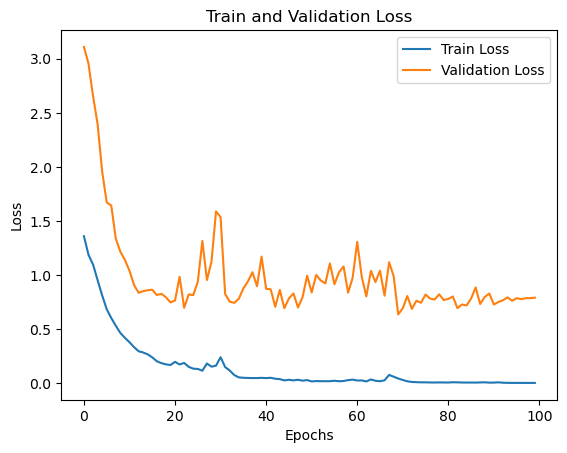

In [57]:
import matplotlib.pyplot as plt

# 주어진 데이터
train_loss = [x for x in arr[0][0]] # train loss 데이터
valid_loss = arr[0][1]  # validation loss 데이터
# 
# train_loss = np.array([round(x, 4) for x in train_loss])
# valid_loss = np.array([round(x, 4) for x in valid_loss])
# 그래프 그리기

plt.plot(range(len(train_loss)), train_loss, label='Train Loss')
plt.plot(range(len(valid_loss)), valid_loss, label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
